In [2]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tabulate
#from recsysNN_utils import *
pd.set_option("display.precision", 1)

2023-07-19 12:17:39.042209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 12:17:39.173200: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-07-19 12:17:39.173294: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2023-07-19 12:17:39.173494: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-1

## Content-based filtering with a neural network


<figure>
    <img src="RecSysNN.png"   style="width:500px;height:280px;" >
</figure>

```python
from numpy import genfromtxt

offers_train_ = genfromtxt('Offers_Train_Data.csv', delimiter=',')[:,2:]
user_train = genfromtxt('User_Train_Data.csv', delimiter=',')
y_train_    = genfromtxt('Conversions_Label_Train_data.csv', delimiter=',')

import pandas as pd
user_df = pd.DataFrame(user_train)
user_df[3] = user_df[3].fillna(
    user_df[3].quantile(0.5)
)
user_train = user_df.values
```

In [3]:
#user_df.head()

In [3]:
user_train_ = pd.read_parquet("s3://adl-core-sagemaker-studio/external/DSaaS/Anas/Rec Sys/User_Features_5977_Full_Volume.parquet")
#user_train_.drop(
   # user_train_.index[user_train_.segment_id.isin(
       # ['ODellCaptivate_Livongo_Pre_Diabetes',
         #'ODellFindaPCPER',
         #'ODELL_OptimizeFinancialWellness_Older_highrisk'])], inplace=True)

In [4]:
user_train_.head()

,data_source_clientid,data_source_personid,segment_id,eligibility_start_date,one_yr_lookup_date,conversion_flag,num_unique_offers_elig_till_start_date,num_conversions_till_start_date,person_internal_id,client_id,...,EMP_STATUS_Enrolled_QDRO,EMP_STATUS_LOA_Family_Medical,EMP_STATUS_LOA_Military,EMP_STATUS_LOA_No_Pay,EMP_STATUS_LOA_With_Pay,EMP_STATUS_LOA_Workers_Compensation,EMP_STATUS_Layoff,EMP_STATUS_Retired,EMP_STATUS_Severance_Pay,EMP_STATUS_Termination
0,5977,10032,ODellNewHireEnrl,2021-08-05 00:08:00,2020-08-05 00:08:00,1,0,0,10032,5977,...,0,0,0,0,0,0,0,0,0,0
1,5977,10032,ODellNewHireRgstrWellnessHub,2021-08-11 00:08:00,2020-08-11 00:08:00,0,2,1,10032,5977,...,0,0,0,0,0,0,0,0,0,0
2,5977,10032,ODellOptimizeFinancialWellness,2021-08-11 00:08:00,2020-08-11 00:08:00,0,2,1,10032,5977,...,0,0,0,0,0,0,0,0,0,0
3,5977,10032,O0006,2021-08-12 00:08:00,2020-08-12 00:08:00,0,4,1,10032,5977,...,0,0,0,0,0,0,0,0,0,0
4,5977,10032,O0005,2021-08-12 00:08:00,2020-08-12 00:08:00,1,4,1,10032,5977,...,0,0,0,0,0,0,0,0,0,0


In [5]:
user_train_.shape

(1916041, 120)

In [9]:
#np.sum((user_train_.values != user_train).astype(int))

In [17]:
#user_train = user_train.sample(n=len(user_train)).reset_index(drop=True)

#user_train.shape

In [7]:
offer_features = pd.read_parquet("s3://adl-core-sagemaker-studio/external/DSaaS/Anas/Rec Sys/Offer_features_5977_full_volume.parquet")

In [13]:
user_train_.drop(user_train_.index[~user_train_.segment_id.isin(offer_features.segment_id.unique())], inplace=True)

In [14]:
user_train_.reset_index(drop=True, inplace=True)

In [15]:
user_train_.shape

(1915560, 120)

In [16]:
y_train_ = user_train_.conversion_flag.values

offers_train_ = (
    user_train_[["segment_id"]].merge(offer_features, how="left", on="segment_id")
    .drop(["segment_id","Description"], axis=1)
).values

In [17]:
offers_train_.shape

(1915560, 24)

In [19]:
offers_train_[np.isnan(offers_train_)]

array([], dtype=float64)

In [20]:
user_train_ = user_train_.drop(["data_source_clientid","data_source_personid",
                              "person_internal_id", "client_id",
                              "segment_id","eligibility_start_date",
                              "one_yr_lookup_date","conversion_flag"], axis=1)

In [21]:
user_train_.shape

(1915560, 112)

In [22]:
columns_index = {k:v for v,k in enumerate(user_train_.columns)}

In [23]:
features_dict = \
{
    "features_list_1":["num_unique_offers_elig_till_start_date",
                       "num_conversions_till_start_date"],
    "features_list_2":["num_unique_offers_elig_till_start_date",
                       "num_conversions_till_start_date","age"],
    "features_list_3":["num_unique_offers_elig_till_start_date",
                       "num_conversions_till_start_date","age",
                       "base_pay_regular_expectedannualsalary"],
    "features_list_4":["num_unique_offers_elig_till_start_date",
                       "num_conversions_till_start_date",
                       "base_pay_regular_expectedannualsalary"],
    "features_list_5":["num_unique_offers_elig_till_start_date",
                       "num_conversions_till_start_date","age",
                       "base_pay_regular_expectedannualsalary",
                        'G_F', 'G_M', 'G_UNKNOWN'],
    "features_list_5":["num_unique_offers_elig_till_start_date",
                       "num_conversions_till_start_date","age",
                       "base_pay_regular_expectedannualsalary",
                        'G_F', 'G_M', 'G_UNKNOWN'],
     "features_list_6":["num_unique_offers_elig_till_start_date",
                       "num_conversions_till_start_date","age",
                       "base_pay_regular_expectedannualsalary",
                        'G_F', 'G_M', 'G_UNKNOWN','EMP_STATUS_Active', 
                        'EMP_STATUS_COBRA_Dependent', 'EMP_STATUS_COBRA_Employee',
                        'EMP_STATUS_DNM', 'EMP_STATUS_Deceased_In_Service', 
                        'EMP_STATUS_Deceased_Outofservice', 
                        'EMP_STATUS_Disability_Long_Term', 
                        'EMP_STATUS_Disability_Short_Term',
                        'EMP_STATUS_Enrolled_Beneficiary', 
                        'EMP_STATUS_Enrolled_QDRO', 
                        'EMP_STATUS_LOA_Family_Medical', 
                        'EMP_STATUS_LOA_Military', 'EMP_STATUS_LOA_No_Pay', 
                        'EMP_STATUS_LOA_With_Pay', 
                        'EMP_STATUS_LOA_Workers_Compensation', 
                        'EMP_STATUS_Layoff', 'EMP_STATUS_Retired', 
                        'EMP_STATUS_Severance_Pay', 'EMP_STATUS_Termination'],
    "features_list_7":user_train_.columns.tolist()
}
 

In [24]:
user_train_ = user_train_.values

In [25]:
new_feataures_dict = features_dict.copy()
for k,v in features_dict.items():
    new_feataures_dict[k] = [columns_index[col] for col in v]

```python
user_features = pd.read_csv("s3://adl-core-sagemaker-studio/external/DSaaS/Anas/Rec Sys/User_Features_5977.csv")
user_features.drop(
    user_features.index[user_features.segment_id.isin(['ODellCaptivate_Livongo_Pre_Diabetes', 'ODellFindaPCPER',
       'ODELL_OptimizeFinancialWellness_Older_highrisk'])], inplace=True)


offer_features = pd.read_csv("s3://adl-core-sagemaker-studio/external/DSaaS/Anas/Rec Sys/Offer_features_5977.csv")

import random
random.seed(98)
total_participants = user_features.data_source_personid.nunique()
all_ppts = user_features.data_source_personid.unique().tolist()
randomlist = random.sample(range(0, total_participants), round(0.9*total_participants))
train_ppts = [all_ppts[i] for i in randomlist]
test_ppts = [id_ for id_ in all_ppts if id_ not in train_ppts]

user_train = user_features.loc[user_features.data_source_personid.isin(train_ppts),:].reset_index(drop=True)
y_train = user_train.conversion_flag.values
offers_train = (
    user_train[["segment_id"]].merge(offer_features, how="left", on="segment_id")
    .drop(["segment_id","Description"], axis=1)
).values

user_train = user_train.drop(["data_source_clientid","data_source_personid",
                              "person_internal_id", "client_id",
                              "segment_id","eligibility_start_date",
                              "one_yr_lookup_date","conversion_flag"], axis=1).values

user_test = user_features.loc[user_features.data_source_personid.isin(test_ppts),:].reset_index(drop=True)
y_test = user_test.conversion_flag.values
offers_test = (
    user_test[["segment_id"]].merge(offer_features, how="left", on="segment_id")
    .drop(["segment_id","Description"], axis=1).values
)
user_test = user_test.drop(["data_source_clientid","data_source_personid",
                              "person_internal_id", "client_id",
                              "segment_id","eligibility_start_date",
                              "one_yr_lookup_date","conversion_flag"]
                           , axis=1).values
```

In [26]:
print(f"Number of training vectors: {len(offers_train_)}")

Number of training vectors: 1915560


### Building the NN architecture

In [27]:
def create_model(l1, l2, num_outputs):

    tf.random.set_seed(1)
    user_NN = tf.keras.models.Sequential([
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(l1, activation="relu", name="U1"),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(l2, activation="relu", name="U2"),
        tf.keras.layers.Dense(num_outputs, activation="linear",
                              name="User_embeddings")
    ])

    offers_NN = tf.keras.models.Sequential([
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(l1, activation="relu", name="M1"),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(l2, activation="relu", name="M2"),
        tf.keras.layers.Dense(num_outputs, activation="linear",
                              name="Offers_embeddings")  
    ])

    # create the user input and point to the base network
    input_user = tf.keras.layers.Input(shape=(num_user_features))
    vu = user_NN(input_user)
    vu = tf.linalg.l2_normalize(vu, axis=1)

    # create the offers input and point to the base network
    input_offers = tf.keras.layers.Input(shape=(num_offers_features))
    vm = offers_NN(input_offers)
    vm = tf.linalg.l2_normalize(vm, axis=1)

    # compute the dot product of the two vectors vu and vm
    output = tf.keras.layers.Dot(axes=1)([vu, vm])
    # specify the inputs and output of the model
    model = tf.keras.Model([input_user, input_offers], output)
    
    cost_fn = tf.keras.losses.BinaryCrossentropy()
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss=cost_fn)
    
    print(model.summary())
    
    return model

### Preparing the training data / Model Training

In [40]:
models_history = []

for key,value in new_feataures_dict.items():
    
    user_train = user_train_.copy()[:,value]
    
    X = pd.concat([pd.DataFrame(user_train), pd.DataFrame(offers_train_)], axis=1)
    
    print(f"Features List: {features_dict[key]}\n")
    
    num_user_features = user_train.shape[1] 
    num_offers_features = offers_train_.shape[1]

    print("Number of User Features: ", num_user_features)
    print("\n")
    print("Number of Offer Features: ", num_offers_features)
    print("\n")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_train_, 
                                                        test_size=0.9, 
                                                        shuffle=True, 
                                                        random_state=42)
    
    user_train = X_train.iloc[:,:num_user_features].values
    offers_train = X_train.iloc[:,num_user_features:].values
    
    user_test = X_test.iloc[:,:num_user_features].values
    offers_test = X_test.iloc[:,num_user_features:].values
    
    #offers_train, offers_test = train_test_split(offers_train_, 
     #                                            train_size=0.9,
      #                                           shuffle=True, 
       #                                          random_state=1)

   # train, user_test = train_test_split(train, 
                                       # train_size=0.9, 
                                        #shuffle=True, 
                                       # random_                                        state=1)

   # y_train, y_test = train_test_split(y_train_,    
                        #               train_size=0.9, 
                         #              shuffle=True, 
                          #             random_state=1)

    #print(f"User training data shape: {user_train.shape}")
    #print(f"User test data shape: {user_test.shape}")
    #print("\n")
    #print(f"Offers training data shape: {offers_train.shape}")
    #print(f"Offers test data shape: {offers_test.shape}")
    #print("\n\n")
    #print(f"y_train distribution: ", pd.DataFrame(y_train).value_counts())
    #print(f"y_est distribution: ", pd.DataFrame(y_test).value_counts())
    #print("\n\n")
    offers_train_unscaled = offers_train
    user_train_unscaled = user_train

    scaleroffers = StandardScaler()
    scaleroffers.fit(offers_train)
    offers_train = scaleroffers.transform(offers_train)

    scalerUser = StandardScaler()
    scalerUser.fit(user_train)
    user_train = scalerUser.transform(user_train)

    offers_test = scaleroffers.transform(offers_test)
    user_test = scalerUser.transform(user_test)

    print("Offers_train_unscaled matches inverse transform: ", 
          np.allclose(offers_train_unscaled, 
                      scaleroffers.inverse_transform(offers_train)))
    
    print("User_train_unscaled matches inverse transform: ",
          np.allclose(user_train_unscaled, scalerUser.inverse_transform(user_train)))
    
    
    # Create Model
    l1, l2, num_outputs = 128, 64, 32
    model = create_model(l1, l2, num_outputs)
    
    tf.random.set_seed(1)
    with tf.device('/GPU:0'):
        training = model.fit([user_train, offers_train],
                             y_train,
                             batch_size=1024,
                             validation_data=([user_test, offers_test], 
                                              y_test), 
                             epochs=20)
    
    models_history.append(training)
    

Features List: ['num_unique_offers_elig_till_start_date', 'num_conversions_till_start_date']

Number of User Features:  2


Number of Offer Features:  24


Offers_train_unscaled matches inverse transform:  True
User_train_unscaled matches inverse transform:  True
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 24)]         0           []                               
                                                                                                  
 sequential_4 (Sequential)      (None, 32)           10720       ['input_5[0][0]']                
                          

```python
all_indices = np.where(user_train_unscaled != scalerUser.inverse_transform(user_train))

print("List of some indices in user_train where the inverse transform dosen't match to user_train_unscaled :\n")
indices_list = []
for r,c in zip(all_indices[0], all_indices[1]):
    indices_list.append((r,c))
    if r == 7: break
print(indices_list)

user_train_inv_trans = scalerUser.inverse_transform(user_train)
for index in indices_list:
    print(f"Index {index}", user_train_unscaled[index[0],index[1]], user_train_inv_trans[index[0],index[1]])
```

In [43]:
models_history

In [44]:
ax.shape

(7, 2)

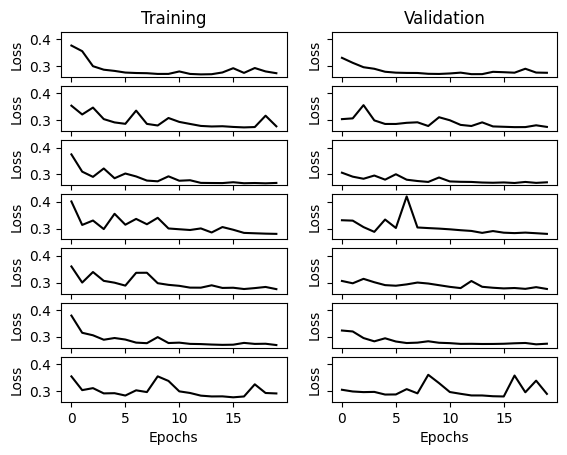

In [55]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(50,100))

fig, ax = plt.subplots(nrows=len(models_history), ncols=2, sharey=True)

#for i,training in enumerate(models_history):

ax[0][0].set(title="Training")
ax[0][0].plot(models_history[0].history['loss'], color='black')
ax[0][0].set_xlabel('Epochs')
ax[0][0].set_ylabel('Loss', color='black')


ax[0][1].set(title="Validation")
ax[0][1].plot(models_history[0].history['val_loss'], color='black')
ax[0][1].set_xlabel('Epochs')
ax[0][1].set_ylabel('Loss', color='black')

ax[1][0].plot(models_history[1].history['loss'], color='black')
ax[1][0].set_xlabel('Epochs')
ax[1][0].set_ylabel('Loss', color='black')


ax[1][1].plot(models_history[1].history['val_loss'], color='black')
ax[1][1].set_xlabel('Epochs')
ax[1][1].set_ylabel('Loss', color='black')

ax[2][0].plot(models_history[2].history['loss'], color='black')
ax[2][0].set_xlabel('Epochs')
ax[2][0].set_ylabel('Loss', color='black')


ax[2][1].plot(models_history[2].history['val_loss'], color='black')
ax[2][1].set_xlabel('Epochs')
ax[2][1].set_ylabel('Loss', color='black')

ax[3][0].plot(models_history[3].history['loss'], color='black')
ax[3][0].set_xlabel('Epochs')
ax[3][0].set_ylabel('Loss', color='black')


ax[3][1].plot(models_history[3].history['val_loss'], color='black')
ax[3][1].set_xlabel('Epochs')
ax[3][1].set_ylabel('Loss', color='black')

ax[4][0].plot(models_history[4].history['loss'], color='black')
ax[4][0].set_xlabel('Epochs')
ax[4][0].set_ylabel('Loss', color='black')


ax[4][1].plot(models_history[4].history['val_loss'], color='black')
ax[4][1].set_xlabel('Epochs')
ax[4][1].set_ylabel('Loss', color='black')

ax[5][0].plot(models_history[5].history['loss'], color='black')
ax[5][0].set_xlabel('Epochs')
ax[5][0].set_ylabel('Loss', color='black')


ax[5][1].plot(models_history[5].history['val_loss'], color='black')
ax[5][1].set_xlabel('Epochs')
ax[5][1].set_ylabel('Loss', color='black')

ax[6][0].plot(models_history[6].history['loss'], color='black')
ax[6][0].set_xlabel('Epochs')
ax[6][0].set_ylabel('Loss', color='black')


ax[6][1].plot(models_history[6].history['val_loss'], color='black')
ax[6][1].set_xlabel('Epochs')
ax[6][1].set_ylabel('Loss', color='black')
    #plt.tight_layout()
plt.show();